Importuję biblioteki

In [1]:

from langchain.document_loaders import DirectoryLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.llms import HuggingFacePipeline
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
import matplotlib.pyplot as plt
from langchain.chains import RetrievalQA
from langchain.schema import BaseRetriever
from langchain.schema import Document


C:\Users\pilcz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Wczytuje artykuły z plików PDF

In [2]:
loader=DirectoryLoader('DANEPDF', glob="**/*.pdf", loader_cls=PyPDFLoader)
documents=loader.load()
print(f"Załadowano {len(documents)} dokumentów")

Załadowano 119 dokumentów


Dzielę artykuły na mniejsze fragmenty aby model lepiej działał, dodatkowo dla lepszego podziału dodaję separatory

In [3]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=150)
chunki = text_splitter.split_documents(documents)
print(f"Podzielono na {len(chunki)} fragmentów.")


Podzielono na 814 fragmentów.


Wybieram 3 modele aby porównać z nich odpowiedzi oraz tworzę wektorową bazę danych dla każdego z nich, zapisuję ją na dysku aby przy kolejnych uruchomienach jedynie ją wczytywać

In [4]:
models={"jeden":"sentence-transformers/all-MiniLM-L6-v2", "dwa":"sentence-transformers/paraphrase-mpnet-base-v2", "trzy":"intfloat/e5-small"}
wektory={}
for n, model in models.items():
    e=HuggingFaceEmbeddings(model_name=model)
    w=Chroma.from_documents(documents=chunki, embedding=e, persist_directory=f"chroma_{n.lower()}", collection_name=f"fishing_{n.lower()}")
    w.persist()
    wektory[n]=w


C:\Users\pilcz\AppData\Local\Temp\ipykernel_9080\379429174.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  e=HuggingFaceEmbeddings(model_name=model)
C:\Users\pilcz\AppData\Local\Temp\ipykernel_9080\379429174.py:6: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  w.persist()


Pipeline QA, za model wybrałem roberta-base-squad2 i wybieram aby operacje wykonywały się wyłącznie na CPU(wolniejsze ale stabilniejsze)

In [5]:

qa_pipeline = pipeline(
    "question-answering",
    model="deepset/roberta-base-squad2", 
    device=-1
)

qa_llm = HuggingFacePipeline(pipeline=qa_pipeline)
print("Zainicjalowano model text-generation: facebook/opt-125m")


Device set to use cpu


Zainicjalowano model text-generation: facebook/opt-125m


C:\Users\pilcz\AppData\Local\Temp\ipykernel_9080\2990151580.py:7: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  qa_llm = HuggingFacePipeline(pipeline=qa_pipeline)


Dla każdego modelu tworzę chain który szuka najlepszego dopasowania pośród dokumentów do inputu użytkownika, miałem problem że model zwracał jedynie pare słów lub szczątkowe informacje do pytania więc do najtrafniejszego dopasowania dodaję również 100 znaków przed i 300 po znalezionym fragmencie

In [6]:


class SimpleQAChain:
    def __init__(self, retriever, qa_pipeline):
        self.retriever = retriever
        self.qa_pipeline = qa_pipeline
    
    def __call__(self, inputs):
        question = inputs["question"]
        docs = self.retriever.get_relevant_documents(question)
        
        if not docs:
            return {"answer": "Brak dokumentów", "source_documents": []}
        
        try:
            result = self.qa_pipeline(question=question, context=docs[0].page_content)
            answer = result['answer']
            
            if answer in docs[0].page_content:
                start = docs[0].page_content.find(answer)
                extended_start = max(0, start - 100)
                extended_end = min(len(docs[0].page_content), start + len(answer) + 300)
                answer = docs[0].page_content[extended_start:extended_end].strip()
                
        except:
            answer = "Nie mogę odpowiedzieć na to pytanie"
        
        return {"answer": answer, "source_documents": docs}

qa_chains = {}
for nazwa, baza in wektory.items():
    retriever = baza.as_retriever(search_kwargs={"k": 2})
    qa_chains[nazwa] = SimpleQAChain(retriever, qa_pipeline)
    print(f"Chain {nazwa}: OK")


Chain jeden: OK
Chain dwa: OK
Chain trzy: OK


Tworzę pętlę główną programu która dla zbyt dużego scora wywala odpowiedni komunikat, na koniec porównuję scory wszystkich modeli do danego pytania

=== ASYSTENT QA ===
Wpisz 'exit' aby zakończyć


PYTANIE: What is the best weather for fishing?

jeden:


C:\Users\pilcz\AppData\Local\Temp\ipykernel_9080\1636917706.py:8: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = self.retriever.get_relevant_documents(question)


  Odpowiedź: 15 
 
fishing is negatively impacted at the extremes – cold (< 50° F) and very hot (> 95° F) 
temperatures.  Specifically, for each additional day per wave with extreme heat, our estimates 
suggest that the odds of taking a recreational trip is reduced by approximately 2 percent. This has 
important implications since climate change forecasts overwhelmingly suggest the realized
  Źródło: WP-2019-016.pdf, str. 16
  Score: 0.670

dwa:
  Odpowiedź: Brak odpowiedniego kontekstu (score: 7.060)

trzy:
  Odpowiedź: 15 
 
fishing is negatively impacted at the extremes – cold (< 50° F) and very hot (> 95° F) 
temperatures.  Specifically, for each additional day per wave with extreme heat, our estimates 
suggest that the odds of taking a recreational trip is reduced by approximately 2 percent. This has
  Źródło: WP-2019-016.pdf, str. 16
  Score: 0.234


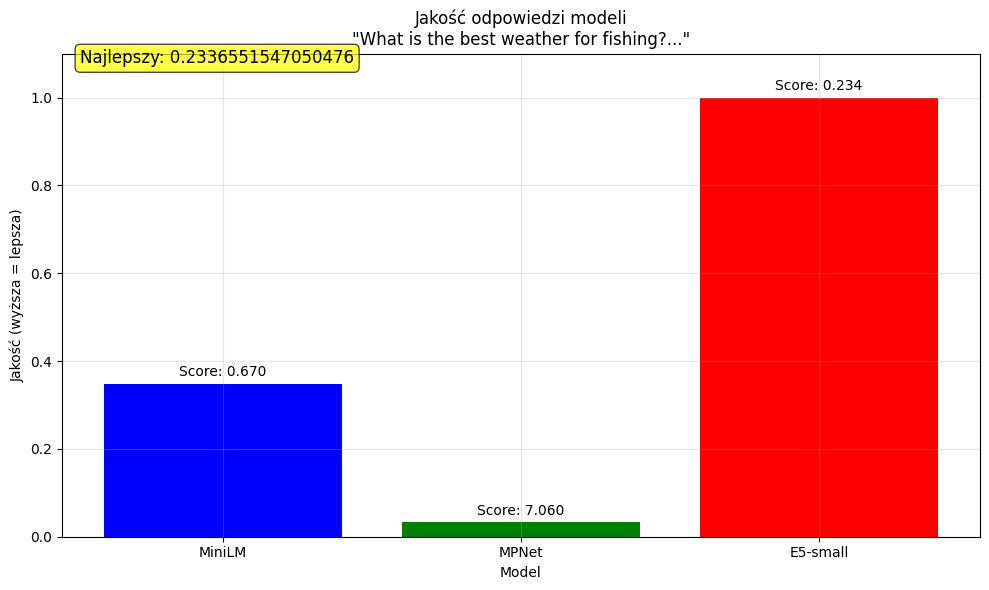


PYTANIE: What is the best fishing bait?

jeden:
  Odpowiedź: (L.)) 
that also aggregate on these Gulf of Maine fishing grounds. In such 
cases, where baited-  hook setups are not used, single-  hook jigs are 
recommended to minimise hook-  removal times and injury rates of 
incidentally captured cod and sublegal haddock.
To ensure acceptance and adoption by anglers, recommended 
terminal tackle must be able to maintain or improve catch rates com -
  Źródło: Fisheries Management Eco - 2021 - Capizzano - Reducing bycatch impacts in recreational fisheries  Case study examining.pdf, str. 10
  Score: 0.729

dwa:
  Odpowiedź: Brak odpowiedniego kontekstu (score: 7.213)

trzy:
  Odpowiedź: true across the full spectrum of baits and jigs available to anglers.
All baited hooks maintained high catch rates for haddock and re -
duced cod bycatch, suggesting anglers would not sacrifice angling 
success if they switched from jigs to baited hooks when targeting
  Źródło: Fisheries Management Eco - 2

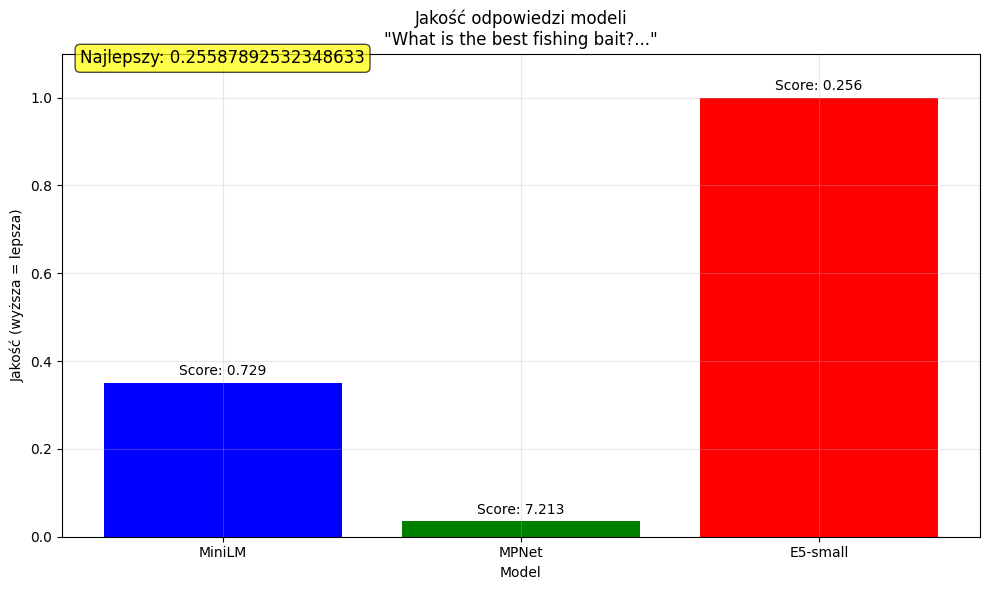


PYTANIE: At what times are fish most active?

jeden:
  Odpowiedź: during fishing operations, that is selectivity (Harrington et al.,  2005), 
particularly in recreational fisheries.
Received: 28 September 2020  | Revised: 3 January 2021  | Accepted: 22 February 2021
DOI: 10.1111/fme.12480  
ORIGINAL ARTICLE
  Źródło: Fisheries Management Eco - 2021 - Capizzano - Reducing bycatch impacts in recreational fisheries  Case study examining.pdf, str. 0
  Score: 0.783

dwa:
  Odpowiedź: Brak odpowiedniego kontekstu (score: 8.980)

trzy:
  Odpowiedź: morning shifts starting just before dawn, 
and evening shifts ending just after sunset. During the ice fish-
ing season, morning shifts lasted from 0600 to 1400 hours and 
evening shifts from 1100 to 1900 hours. Summer season morn-
ing shifts lasted from 0530 to 1330 hours and evening shifts 
from 1330 to 2130 hours.
Anglers were approached twice for interviews, once 
before they started their trip and again after t
  Źródło: Kerkhove_etal_2024_Fi

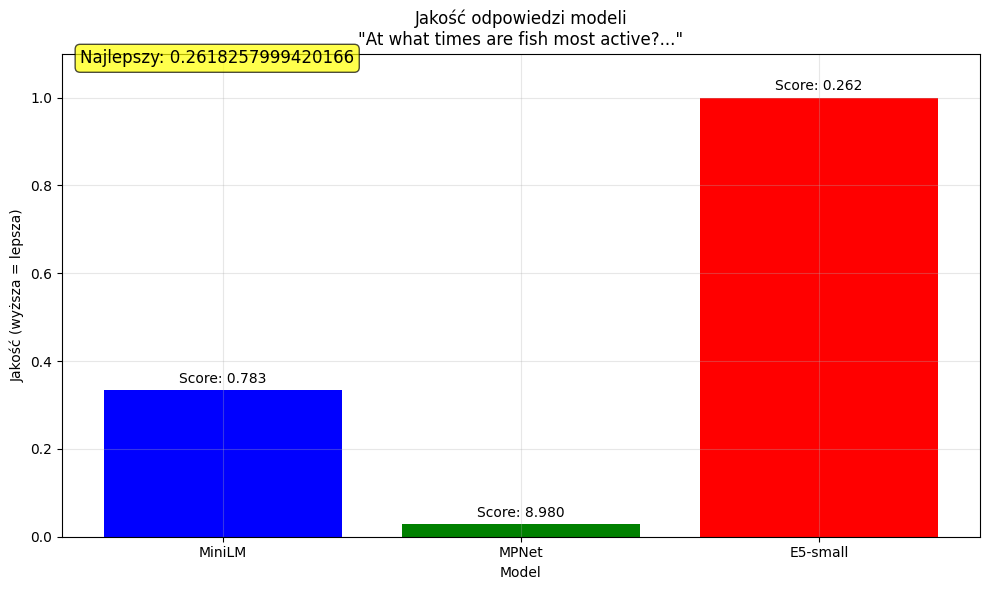


PYTANIE: When did Ozzy Osbourne died?

jeden:
  Odpowiedź: Brak odpowiedniego kontekstu (score: 1.541)

dwa:
  Odpowiedź: Brak odpowiedniego kontekstu (score: 15.196)

trzy:
  Odpowiedź: tional Ecology 15:754-762.
Matlock, G. C., L. W. McEachron, J. A. Dailey, P. A. Unger, and P.
Chai. 1993. Short-term hooking mortalities of red drums and spotted
seatrout caught on single-barb and treble hooks. North American
Journal of Fisheries Management 13:186-189.
McCullagh, P., and J. A Nelder.1989. Generalized linear models, 2nd
edition. Chapman and Hall, London.
Miranda, L. E., and B. S. Dorr.
  Źródło: Lure-size_Restrictions_in_Recreational_Fisheries.pdf, str. 10
  Score: 0.444


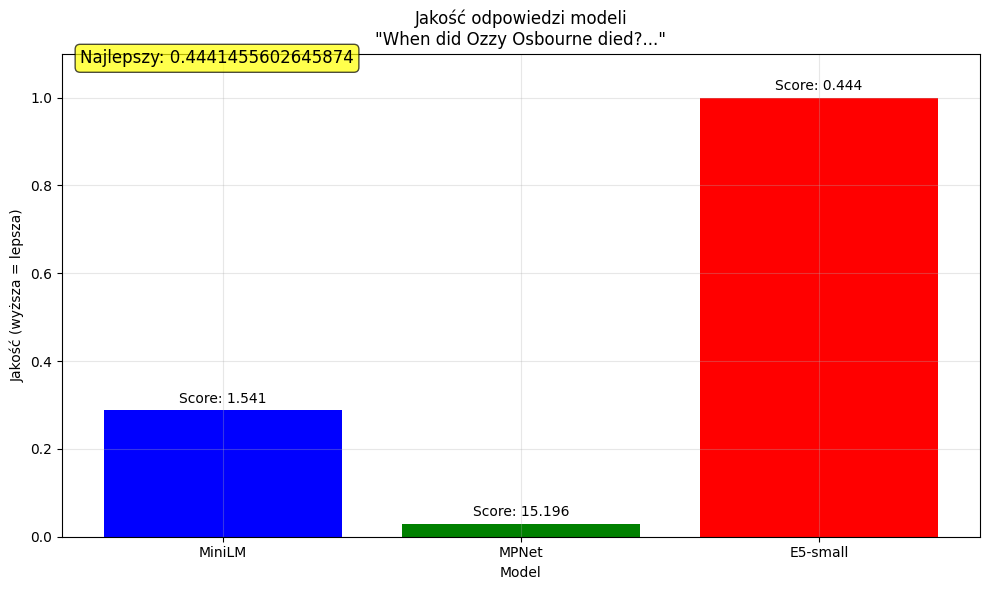


PYTANIE: Are you even good?

jeden:
  Odpowiedź: Brak odpowiedniego kontekstu (score: 1.587)

dwa:
  Odpowiedź: Brak odpowiedniego kontekstu (score: 14.600)

trzy:
  Odpowiedź: overall with your trip today?” and (2) “How satisfied were you 
with the number of fish you caught today?” All data are pub-
licly available (Jensen 2023).
Statistical Analysis
Beyond summarizing the full data set (e.g., number and 
location of interviews), we analyzed a subset of the data (i.e.,
  Źródło: Kerkhove_etal_2024_Fisheries.pdf, str. 3
  Score: 0.405


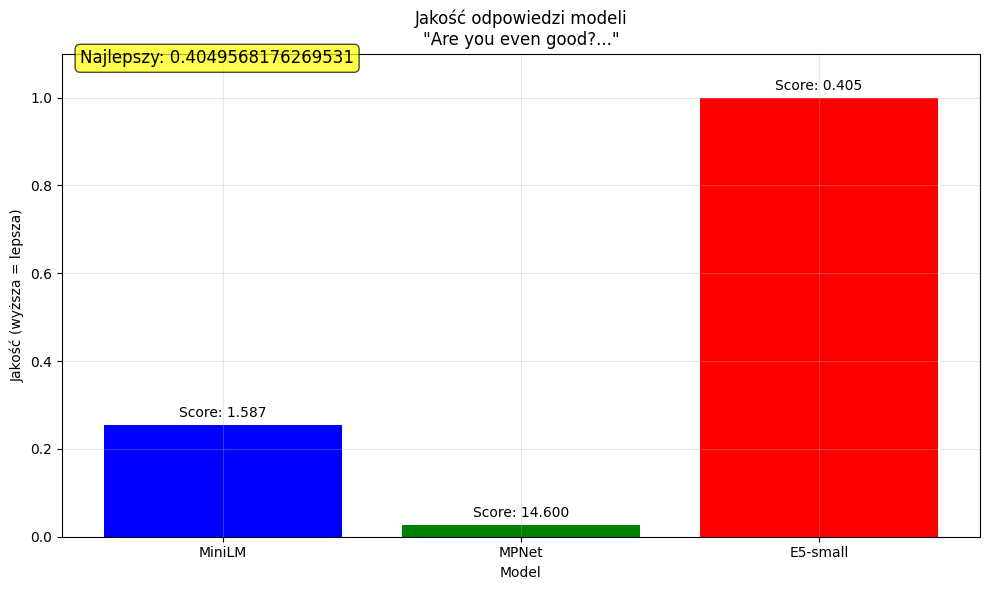

In [7]:
print("=== ASYSTENT QA ===")
print("Wpisz 'exit' aby zakończyć\n")

while True:
    pytanie = input("Pytanie: ")
    if pytanie.lower() == "exit":
        break
    
    print(f"\n{'='*40}")
    print(f"PYTANIE: {pytanie}")
    print('='*40)
    scores=[]
    for nazwa, chain in qa_chains.items():
        print(f"\n{nazwa}:")
        
        try:
            wynik = chain({"question": pytanie})
            odpowiedz = wynik.get("answer", "")
            dokumenty = wynik.get("source_documents", [])
            
            if odpowiedz and dokumenty:
                baza = wektory[nazwa]
                docs_with_scores = baza.similarity_search_with_score(pytanie, k=1)
                score = docs_with_scores[0][1] if docs_with_scores else 1.0
                scores.append(score)
                
                if score > 0.8:
                    print(f"  Odpowiedź: Brak odpowiedniego kontekstu (score: {score:.3f})")
                else:
                    print(f"  Odpowiedź: {odpowiedz}")
                    plik = dokumenty[0].metadata.get('source', '').split('\\')[-1]
                    strona = dokumenty[0].metadata.get('page', 'N/A')
                    print(f"  Źródło: {plik}, str. {strona}")
                    print(f"  Score: {score:.3f}")
            else:
                print("  Brak odpowiedzi")
                
        except Exception as e:
            print(f"  Błąd: {str(e)[:50]}...")
    heights=[1/max(s, 0.01) for s in scores]
    max_height = max(heights)
    heights = [h/max_height for h in heights]
    names=["MiniLM", "MPNet", "E5-small"]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, heights, color=['blue', 'green', 'red'])

    for i, (bar, score) in enumerate(zip(bars, scores)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'Score: {score:.3f}', ha='center', va='bottom')
    
    plt.title(f'Jakość odpowiedzi modeli\n"{pytanie[:50]}..."')
    plt.xlabel('Model')
    plt.ylabel('Jakość (wyższa = lepsza)')
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)
    
    best_model = min(scores)
    plt.text(0.02, 0.98, f'Najlepszy: {best_model}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    plt.tight_layout()
    plt.show()
    print('='*40)

Podsumowując, model E5-small generował najlepsze scory oraz znajdywał najlepsze, najbardziej zadowalające fragmenty. Jednakże dla mniej tematycznych pytań zamiast wywalić błąd, wciąż podawał odpowiedzi(Mimo to fragmenty odpowiedzi za każdym razem miały jakiś związek z pytaniem, mimo iż pytania odbiegały znacznie tematem danych modelu). MiniLM działał... poprawnie, chociaż scorem oraz samymi odpowiedziami odbiegał od E5 to dalej solidny model. MPNet wgl nie współpracował, totalna porażka. W konkluzji do tych wnisków uważam że gdyby zostawić E5-small i zmniejszyć mu maksymalny score aby nie szukał odpowiedzi na siłę to byłoby to najlepsze rozwiązanie.